In [1]:
# !pip install -q transformers
# !pip install -q datasets jiwer

In [2]:
# !tar -xvf "/content/drive/MyDrive/TrOCR/dataset/IAM.tar.gz" -C "/content/"

In [3]:
import pandas as pd

df = pd.read_fwf('/content/IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df.drop(2, inplace=True, axis=1)
# some file names aend with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# We reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(os.path.join(self.root_dir, file_name)).convert('RGB')
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        labels = self.processor.tokenizer(text, padding='max_length', max_length=self.max_target_length).input_ids
        
        # make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir = '/content/IAM/image',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir = '/content/IAM/image',
                           df=test_df,
                           processor=processor)

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2332
Number of validation examples: 583


In [8]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


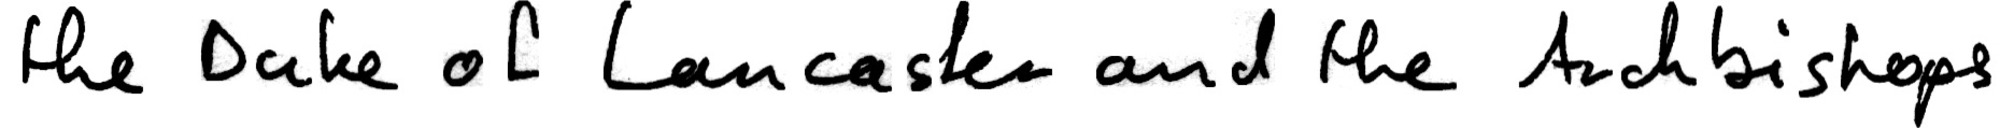

In [9]:
image = Image.open(os.path.join(train_dataset.root_dir, train_df['file_name'][0])).convert("RGB")
image

In [10]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

the Duke of Lancaster and the Archbishops


In [11]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# set special tokens used for createing the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [13]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    num_train_epochs=10,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    fp16=True,
    output_dir="/content/checkpoints/",
    logging_steps=2,
    save_steps = 1000,
    eval_steps=200,
)

In [14]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [15]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer": cer}

In [16]:
from transformers import default_data_collator

# Instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2332
  Num Epochs = 10
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 3890


Step,Training Loss,Validation Loss,Cer
200,2.618600,2.997399,0.492132
400,1.969000,2.090094,0.308679
600,1.830100,2.012722,0.296714
800,1.677700,2.335672,0.353098
1000,1.533400,1.806736,0.233240
1200,0.900300,1.801564,0.244099
1400,0.760200,1.630871,0.211441
1600,0.735300,1.735409,0.253852


***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
Saving model checkpoint to /content/checkpoints/checkpoint-1000
Configuration saved in /content/checkpoints/checkpoint-1000/config.json
Model weights saved in /content/checkpoints/checkpoint-1000/pytorch_model.bin
Feature extractor saved in /content/checkpoints/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6


Step,Training Loss,Validation Loss,Cer
200,2.618600,2.997399,0.492132
400,1.969000,2.090094,0.308679
600,1.830100,2.012722,0.296714
800,1.677700,2.335672,0.353098
1000,1.533400,1.806736,0.233240
1200,0.900300,1.801564,0.244099
1400,0.760200,1.630871,0.211441
1600,0.735300,1.735409,0.253852
1800,0.584900,1.524101,0.184888
2000,0.338400,1.514927,0.186199


***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
Saving model checkpoint to /content/checkpoints/checkpoint-2000
Configuration saved in /content/checkpoints/checkpoint-2000/config.json
Model weights saved in /content/checkpoints/checkpoint-2000/pytorch_model.bin
Feature extractor saved in /content/checkpoints/checkpoint-2000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
***** Running Evaluation *****
  Num examples = 583
  Batch size = 6
Saving model checkpoint to /content/checkpoints/checkpoint-3000
Configuration saved in /content/checkpoints/checkpoint-3000/config.json
Model weights saved in /content/checkpoints/checkpoint-3000/pytorch_model.bin
Feature extractor saved in /content/checkpoints/checkpoint-3000/prepr

TrainOutput(global_step=3890, training_loss=0.8800438205388333, metrics={'train_runtime': 15413.6558, 'train_samples_per_second': 1.513, 'train_steps_per_second': 0.252, 'total_flos': 2.063576190941135e+19, 'train_loss': 0.8800438205388333, 'epoch': 10.0})